D1 Registartion Pipeline & Monitoring
200345N

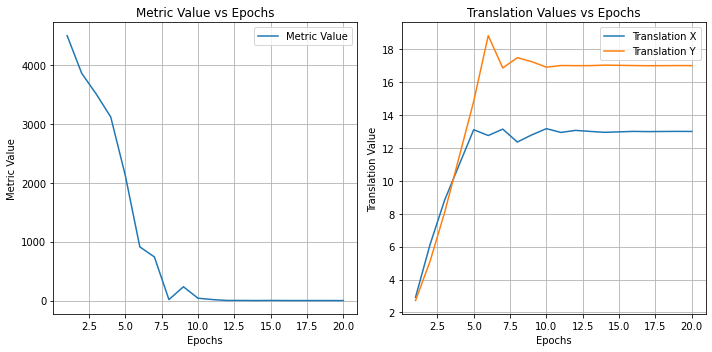

Result = 
 Translation X = 12.99928608126834
 Translation Y = 17.000045636412015
 Iterations    = 20
 Metric value  = 0.00516377784905992


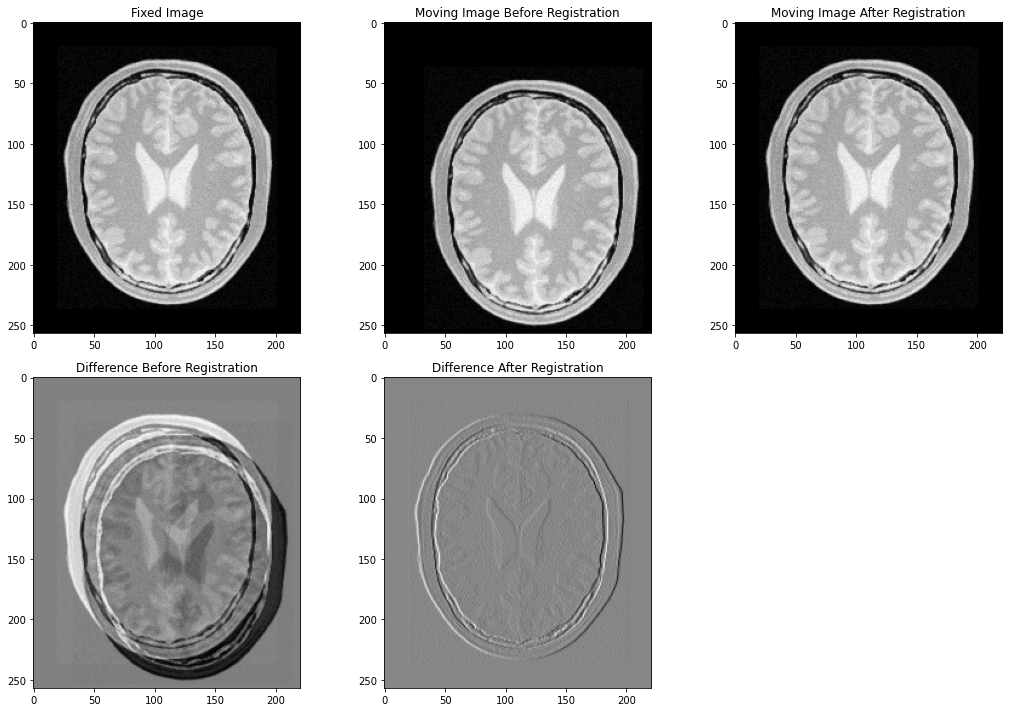

In [1]:
import itk
import matplotlib.pyplot as plt

# Function to perform 2D Translation Registration With Mean Squares
def perform_registration(fixed_image_path, moving_image_path):
    PixelType = itk.ctype("float")

    # Read images
    fixedImage = itk.imread(fixed_image_path, PixelType)
    movingImage = itk.imread(moving_image_path, PixelType)

    Dimension = fixedImage.GetImageDimension()
    FixedImageType = itk.Image[PixelType, Dimension]
    MovingImageType = itk.Image[PixelType, Dimension]

    TransformType = itk.TranslationTransform[itk.D, Dimension]
    initialTransform = TransformType.New()

    metric_values = []
    translation_x_values = []
    translation_y_values = []

    def observer():
        currentParameters = optimizer.GetCurrentPosition()
        translation_x = currentParameters.GetElement(0)
        translation_y = currentParameters.GetElement(1)
        metric_value = optimizer.GetValue()

        metric_values.append(metric_value)
        translation_x_values.append(translation_x)
        translation_y_values.append(translation_y)

    optimizer = itk.RegularStepGradientDescentOptimizerv4.New(
        LearningRate=4,
        MinimumStepLength=0.001,
        RelaxationFactor=0.5,
        NumberOfIterations=20,
    )
    optimizer.AddObserver(itk.IterationEvent(), observer)

    metric = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType].New()

    registration = itk.ImageRegistrationMethodv4.New(
        FixedImage=fixedImage,
        MovingImage=movingImage,
        Metric=metric,
        Optimizer=optimizer,
        InitialTransform=initialTransform,
    )

    movingInitialTransform = TransformType.New()
    initialParameters = movingInitialTransform.GetParameters()
    initialParameters[0] = 0
    initialParameters[1] = 0
    movingInitialTransform.SetParameters(initialParameters)
    registration.SetMovingInitialTransform(movingInitialTransform)

    identityTransform = TransformType.New()
    identityTransform.SetIdentity()
    registration.SetFixedInitialTransform(identityTransform)

    registration.SetNumberOfLevels(1)
    registration.SetSmoothingSigmasPerLevel([0])
    registration.SetShrinkFactorsPerLevel([1])

    registration.Update()

    # Plotting metric and translation values against iterations (epochs)
    epochs = list(range(1, len(metric_values) + 1))

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, metric_values, label="Metric Value")
    plt.xlabel('Epochs')
    plt.ylabel('Metric Value')
    plt.title('Metric Value vs Epochs')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, translation_x_values, label="Translation X")
    plt.plot(epochs, translation_y_values, label="Translation Y")
    plt.xlabel('Epochs')
    plt.ylabel('Translation Value')
    plt.title('Translation Values vs Epochs')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    transform = registration.GetTransform()
    finalParameters = transform.GetParameters()
    translationAlongX = finalParameters.GetElement(0)
    translationAlongY = finalParameters.GetElement(1)

    numberOfIterations = optimizer.GetCurrentIteration()
    bestValue = optimizer.GetValue()

    print("Result = ")
    print(" Translation X = " + str(translationAlongX))
    print(" Translation Y = " + str(translationAlongY))
    print(" Iterations    = " + str(numberOfIterations))
    print(" Metric value  = " + str(bestValue))

    CompositeTransformType = itk.CompositeTransform[itk.D, Dimension]
    outputCompositeTransform = CompositeTransformType.New()
    outputCompositeTransform.AddTransform(movingInitialTransform)
    outputCompositeTransform.AddTransform(registration.GetModifiableTransform())

    resampler = itk.ResampleImageFilter.New(
        Input=movingImage,
        Transform=outputCompositeTransform,
        UseReferenceImage=True,
        ReferenceImage=fixedImage,
    )
    resampler.SetDefaultPixelValue(1)

    OutputPixelType = itk.ctype("unsigned char")
    OutputImageType = itk.Image[OutputPixelType, Dimension]

    # No need to save; cast the images to numpy for visualization
    resampled_moving_image = itk.GetArrayViewFromImage(resampler)

    # Compute difference images
    difference_after = itk.SubtractImageFilter.New(Input1=fixedImage, Input2=resampler.GetOutput())
    difference_before = itk.SubtractImageFilter.New(Input1=fixedImage, Input2=movingImage)

    difference_after.Update()
    difference_before.Update()

    difference_image_after = itk.GetArrayViewFromImage(difference_after)
    difference_image_before = itk.GetArrayViewFromImage(difference_before)

    # Visualize the fixed, moving (before and after), and difference images
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.imshow(itk.GetArrayViewFromImage(fixedImage), cmap="gray")
    plt.title("Fixed Image")

    plt.subplot(2, 3, 2)
    plt.imshow(itk.GetArrayViewFromImage(movingImage), cmap="gray")
    plt.title("Moving Image Before Registration")

    plt.subplot(2, 3, 3)
    plt.imshow(resampled_moving_image, cmap="gray")
    plt.title("Moving Image After Registration")

    plt.subplot(2, 3, 4)
    plt.imshow(difference_image_before, cmap="gray")
    plt.title("Difference Before Registration")

    plt.subplot(2, 3, 5)
    plt.imshow(difference_image_after, cmap="gray")
    plt.title("Difference After Registration")

    plt.tight_layout()
    plt.show()

# Replace these variables with the actual paths to your images
fixed_image_path = 'BrainProtonDensitySliceBorder20.png'
moving_image_path = 'BrainProtonDensitySliceShifted13x17y.png'

# Run the function
perform_registration(fixed_image_path, moving_image_path)
